In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm as tqdm
from torch.autograd import Variable
import numpy as np
import matplotlib.image as mpimg

from train_utils import get_model
from dataset.oscd_dataset import OSCD_Dataset

/home/rakesh/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IMPORTS OK


In [2]:
PATH_TO_PRED = '../../../../DataSet/pred/Apr-05-2023/04_32_22'
PATH_TO_TEST_DATA = '../../../../DataSet/OSCD/'
MODEL_NAME = 'DSIFN_ResNet'
BANDS = ['B01', 'B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10', 'B11','B12']
DS = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dset = OSCD_Dataset(path=PATH_TO_TEST_DATA,
                            fname='test.txt',
                            patch_side=256,
                            stride=128,
                            normalize=True,
                            transform=None,
                            bands=BANDS
                            )

model = get_model(MODEL_NAME,len(BANDS), 2)
model.load_state_dict(torch.load(os.path.join(PATH_TO_PRED, 'model.pth.tar'), map_location=torch.device(device=device)))
print('LOAD OK')
model.eval()

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


=> loading checkpoint '/home/rakesh/LocalRepo/checkpoints_300/checkpoint.pth'
['fc.weight', 'fc.bias']
=> loaded pre-trained model '/home/rakesh/LocalRepo/checkpoints_300/checkpoint.pth'
LOAD OK


DSIFN_ResNet(
  (model): DSIFN(
    (t1_base): resnet18_base(
      (encoder): ResNet(
        (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [4]:
import numpy as np
import matplotlib.pyplot as plt
    
def get_rgb_ndarray(image):

    data = image.numpy()
    
    r = data[3,:,:]
    g = data[2,:,:]
    b = data[1,:,:]

    rgb = np.stack([r,g,b])
    rgb = np.einsum('ijk->jki',rgb)

    return rgb

In [5]:
tp = 0

tp = np.float64(tp)
tn = np.float64(tp)
fp = np.float64(tp)
fn = np.float64(tp)

tot_count = np.float64(tp)
tot_loss = np.float64(tp)

  0%|          | 0/146 [00:00<?, ?it/s]

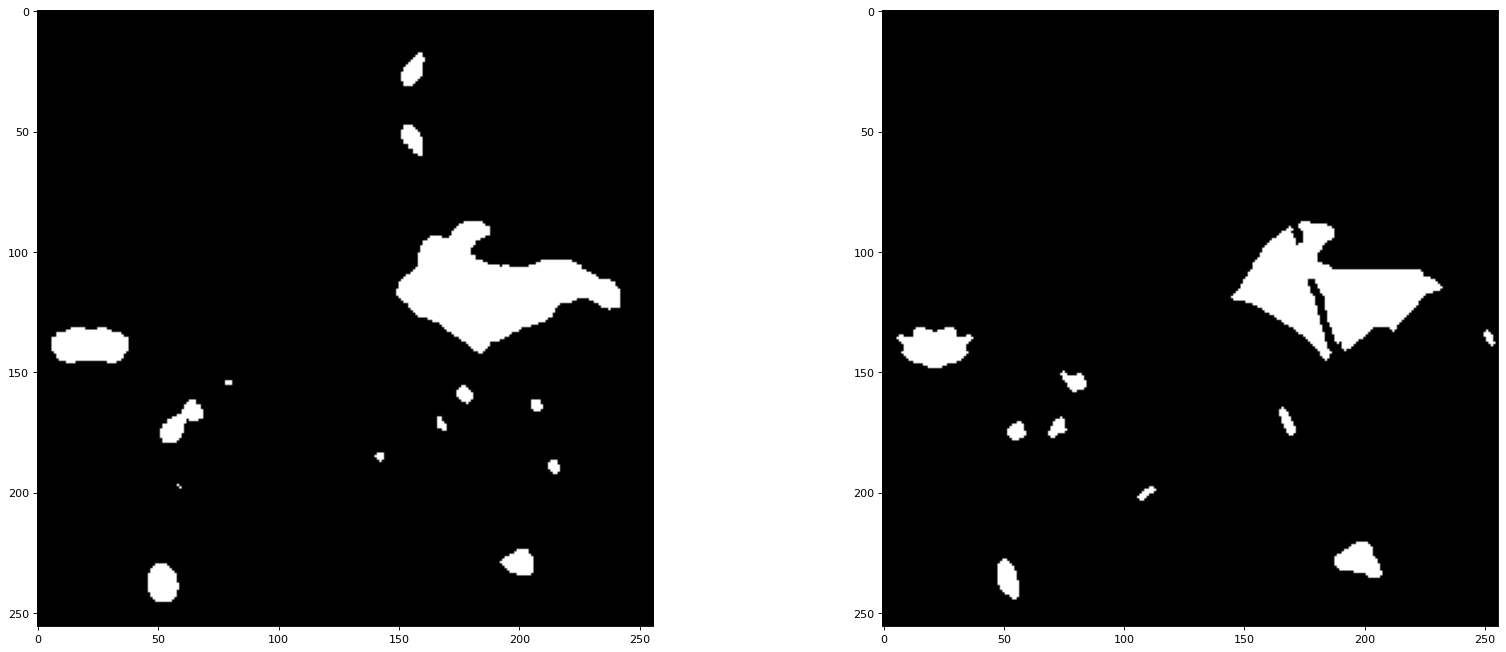

  1%|          | 1/146 [00:00<00:59,  2.45it/s]

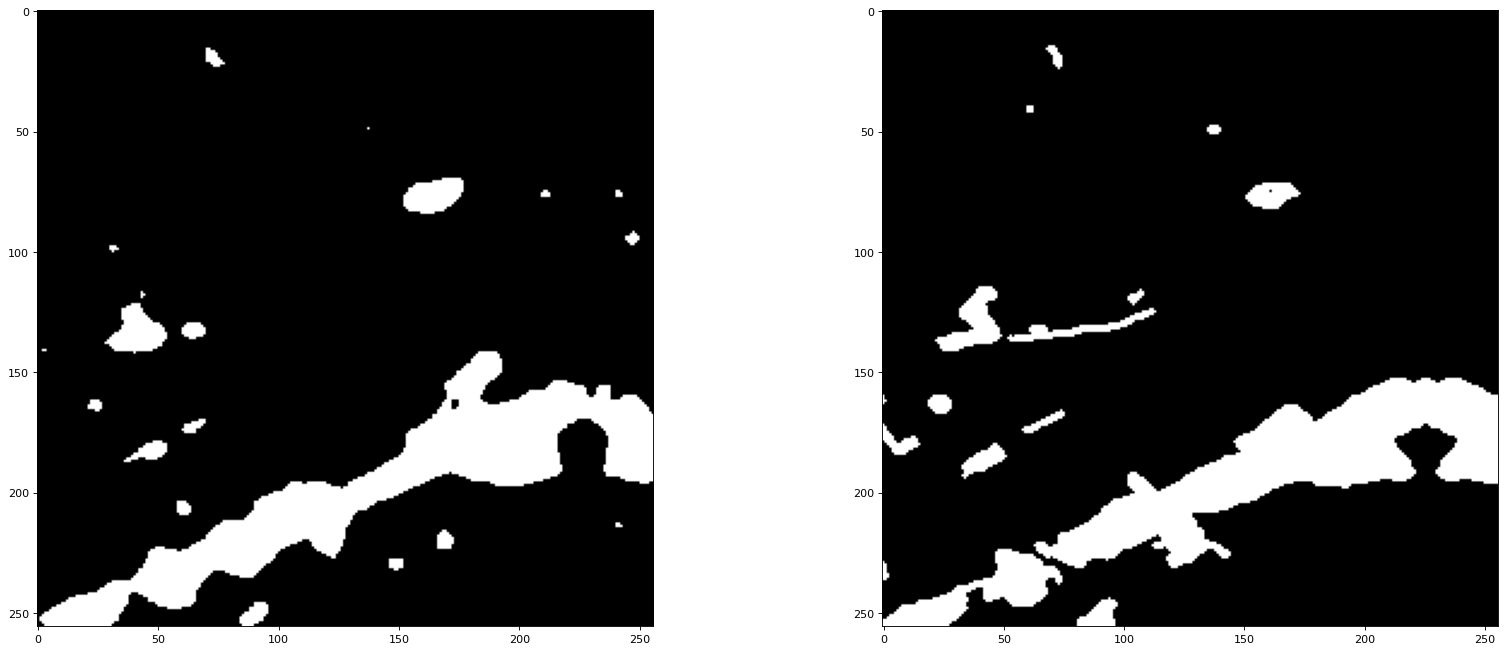

 10%|█         | 15/146 [00:00<00:05, 25.86it/s]

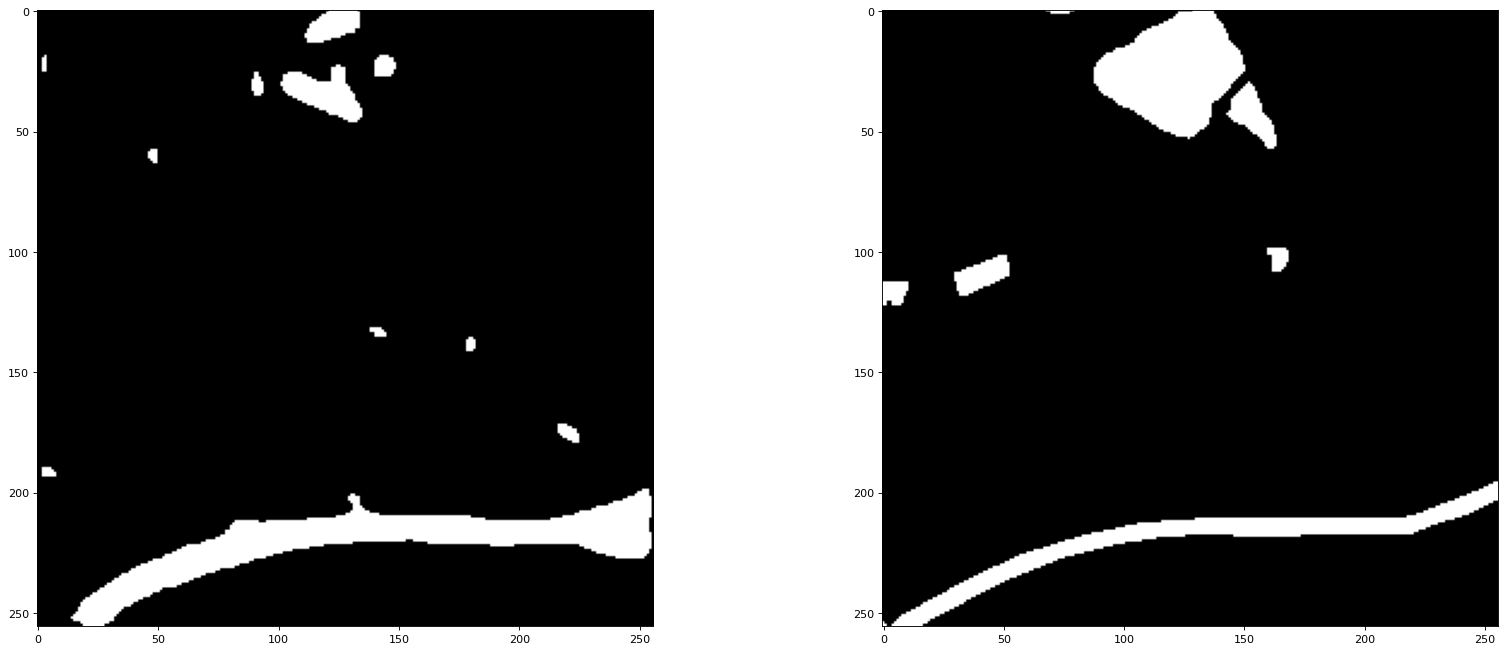

 50%|█████     | 73/146 [00:00<00:00, 99.94it/s]

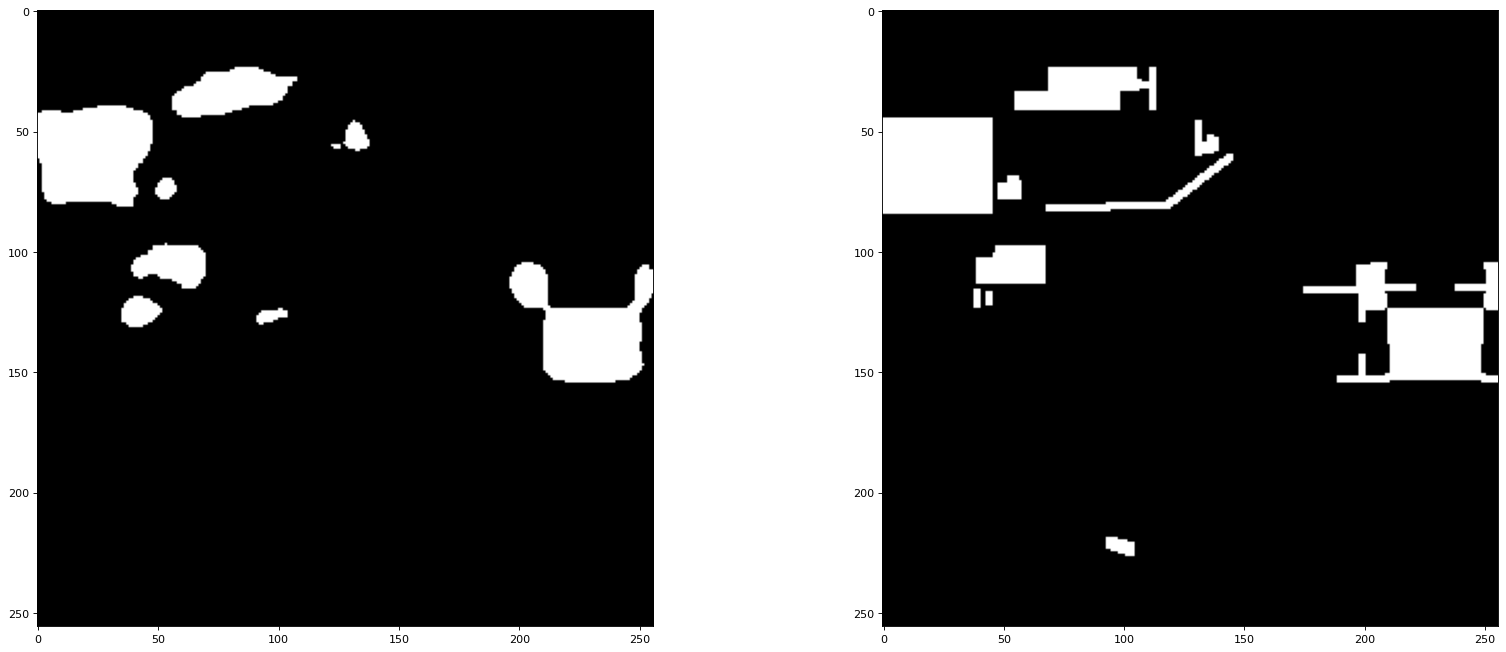

100%|██████████| 146/146 [00:01<00:00, 115.79it/s]


In [7]:
for img_index in tqdm(range(len(dset))):

    if img_index not in (0,14,72,104):
        continue

    sample = dset[img_index]
    I1_full = sample['I1']
    I2_full = sample['I2']
    cm_full = sample['label']
    fname = sample['fname']

    I1 = Variable(torch.unsqueeze(I1_full, 0).float()).to(device)
    I2 = Variable(torch.unsqueeze(I2_full, 0).float()).to(device)
    out = model(I1.float(), I2.float())
    
    output = model(I1.float(), I2.float())
    
    tot_count += np.prod(cm_full.size())

    if DS:
        _, predicted = torch.max(output[0].data, 1)
    else:
        _, predicted = torch.max(output.data, 1)
            
    pr = (predicted.int() > 0).cpu().numpy()
    gt = (cm_full.data.int() > 0).cpu().numpy()

    tp += np.logical_and(pr, gt).sum()
    tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
    fp += np.logical_and(pr, np.logical_not(gt)).sum()
    fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    #For Saving image
    predicted = torch.squeeze(predicted)
    cm = torch.squeeze(cm_full)
    cm = cm.type(torch.uint8)
    predicted = predicted.type(torch.uint8)
    
    # I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
    I = np.stack((255*np.squeeze(predicted.cpu().numpy()),
                    255*np.squeeze(predicted.cpu().numpy()),
                    255*np.squeeze(predicted.cpu().numpy())),2)
    
    # pred_fname = os.path.splitext(fname)[0]+'-'+str(img_index)+'-predicted.png'
    # pred_fname = os.path.join(PATH_TO_PRED, pred_fname)
    # mpimg.imsave(pred_fname,I.astype(np.uint8))
    
    f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(25, 10),dpi=80)
    axarr[0].imshow(I,cmap='gray')
    axarr[1].imshow(cm, cmap='gray')
    plt.show()

In [8]:
net_loss = tot_loss/tot_count        
net_loss = float(net_loss)
smooth = 1e-5
    
prec_nc = tn / (tn + fn)
rec_nc = tn / (tn + fp)

net_accuracy = (tp + tn + smooth)/(tot_count + smooth)
prec = (tp) / (tp + fp + smooth)
rec = (tp) / (tp + fn + smooth)
f_meas = (2 * prec * rec ) / (prec + rec + smooth)
dice = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
N = tp + tn + fp + fn
p0 = (tp + tn + smooth) / (N + smooth)
pe = ( ( tp + fp  ) * ( tp + fn ) + ( tn + fp ) * ( tn + fn ) + smooth ) / (N * N + smooth)
kappa = (p0 - pe + smooth) / (1 - pe + smooth)
jaccard = (tp + smooth) / (tp + fp + fn + smooth)

metrics_list = []
metrics_list.append(f'net_loss: {net_loss}')
metrics_list.append(f'net_accuracy: {net_accuracy}')
metrics_list.append(f'precision: {prec}')
metrics_list.append(f'recall: {rec}')
metrics_list.append(f'dice: {dice}')
metrics_list.append(f'f_meas: {f_meas}')    
metrics_list.append(f'kappa: {kappa}')
metrics_list.append(f'jaccard: {jaccard}')
metrics_list.append(f'prec_nc : {prec_nc}')
metrics_list.append(f'rec_nc : {rec_nc}')

print(metrics_list)

['net_loss: 0.0', 'net_accuracy: 0.9546852111833691', 'precision: 0.7541303584843985', 'recall: 0.5643192485319148', 'dice: 0.6455616889018165', 'f_meas: 0.6455567920781264', 'kappa: 0.6219237308892349', 'jaccard: 0.47662686721741776', 'prec_nc : 0.9662952634998527', 'rec_nc : 0.9854840435602163']
